In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import seaborn_image as isns
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise

from denoising import (
    anisotropic,
    generate_synthetic,
    Environment,
)
from denoising.data import BSD300
from denoising.data.utils import load_grayscale

isns.set_context('notebook')  # this will create thicker lines and larger fonts than usual
isns.set_image(cmap='gray', despine=True)  # set the colormap and despine the axes

In [4]:
# загружаем переменные окружения
env = Environment(_env_file='../env')
env.data

PosixPath('/home/d.nesterov/data')

# Визуализация работы анизотропной диффузии

In [11]:
image = load_grayscale(env.data / 'lena.png') / 255.0

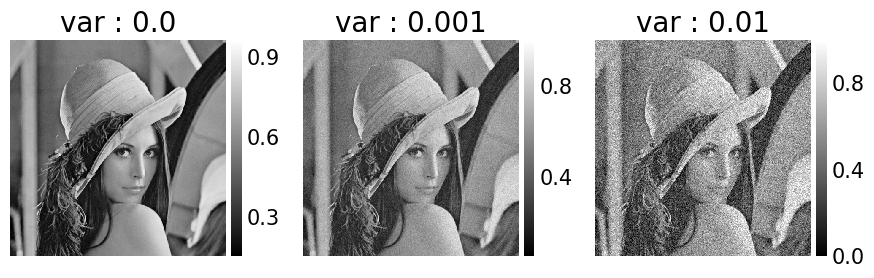

In [12]:
# как выглядит изображение с разным уровнем шума
_ = isns.ParamGrid(image, random_noise, col='var', var=[0.0, 0.001, 0.01], rng=env.random_seed)

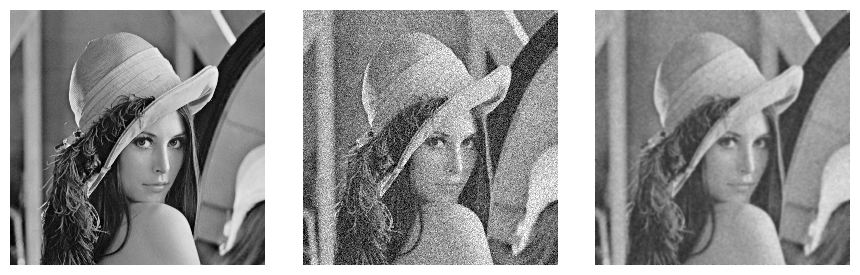

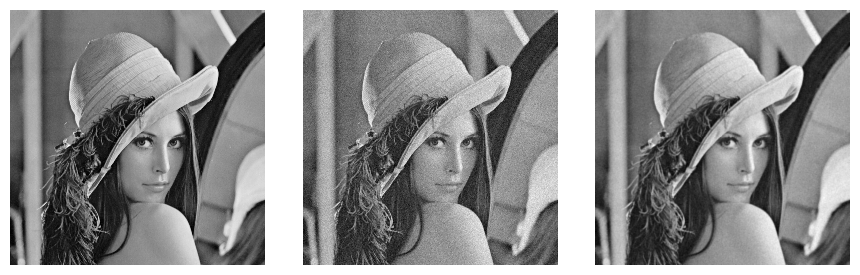

In [13]:
# визуализация результата работы алгоритма с разными variance и с подобранными параметрами
params = [
    {
        'variance': 0.01,
        'iterations': 36,
        't_delta': 0.05,
    },
    {
        'variance': 0.001,
        'iterations': 5,
        't_delta': 0.1,
    },
]

for p in params:
    image_noisy = random_noise(image, rng=env.random_seed, var=p['variance'])
    image_denoised = anisotropic(image_noisy, iterations=p['iterations'], t_delta=p['t_delta'])

    ssim_before = ssim(image, image_noisy, data_range=1.0)
    ssim_after = ssim(image, image_denoised, data_range=1.0)

    _ = isns.ImageGrid([image, image_noisy, image_denoised], cbar=False)

# Оценка качества на датасете BSDS300

In [14]:
# инициализируем датасеты. изображения загружаются в память
dset_train = BSD300(env.data / 'BSDS300', mode='train')
dset_test = BSD300(env.data / 'BSDS300', mode='test')
len(dset_train), len(dset_test)

(200, 100)

In [19]:
# оценим качество для следующих variance
# и при одних и тех же параметрах алгоритма для всех изображений
params = [
    {
        'variance': 0.01,
        'iterations': 10,
        't_delta': 0.05,
    },
    {
        'variance': 0.001,
        'iterations': 5,
        't_delta': 0.1,
    },
]

dset_parts = list(zip([dset_train, dset_test], ['train', 'test'], strict=False))
verbose = False

In [20]:
for p in params:
    for dset, dset_part in dset_parts:
        clean, noisy = generate_synthetic(dset, p['variance'], env.random_seed, verbose=verbose)
        denoised = [
            anisotropic(img, iterations=p['iterations'], t_delta=p['t_delta']) for img in noisy
        ]

        ssim_before = []
        ssim_after = []
        for img_clean, img_noisy, img_denoised in zip(clean, noisy, denoised, strict=False):
            ssim_before.append(ssim(img_clean, img_noisy, data_range=1.0))
            ssim_after.append(ssim(img_clean, img_denoised, data_range=1.0))
        mean_ssim_before = np.mean(ssim_before)
        mean_ssim_after = np.mean(ssim_after)
        ssim_increment = mean_ssim_after - mean_ssim_before

        print(
            f'[Mean SSIM][variance={p["variance"]}][{dset_part}] Before: {mean_ssim_before:.2f}, after: {mean_ssim_after:.2f}, increment: {ssim_increment:.2f}'
        )

[Mean SSIM][variance=0.01][train] Before: 0.39, after: 0.68, increment: 0.29
[Mean SSIM][variance=0.01][test] Before: 0.41, after: 0.68, increment: 0.27
[Mean SSIM][variance=0.001][train] Before: 0.77, after: 0.84, increment: 0.07
[Mean SSIM][variance=0.001][test] Before: 0.79, after: 0.82, increment: 0.03
